In [ ]:
import cv2
import numpy as np

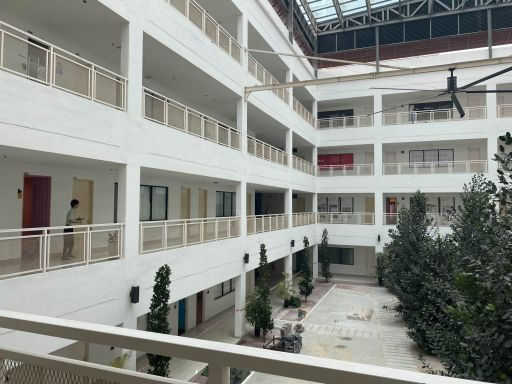

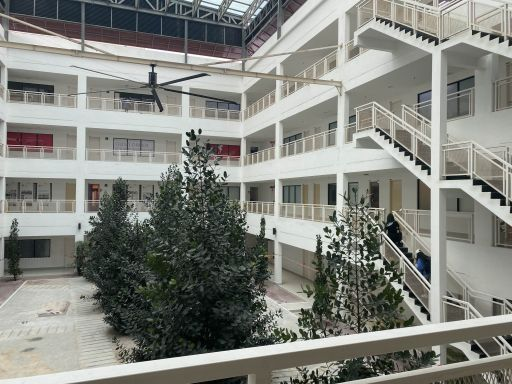

In [ ]:
from google.colab.patches import cv2_imshow
image1 = cv2.imread('pano_02_L.jpg')
image2 = cv2.imread('pano_02_R.jpg')
cv2_imshow(image1)
cv2_imshow(image2)

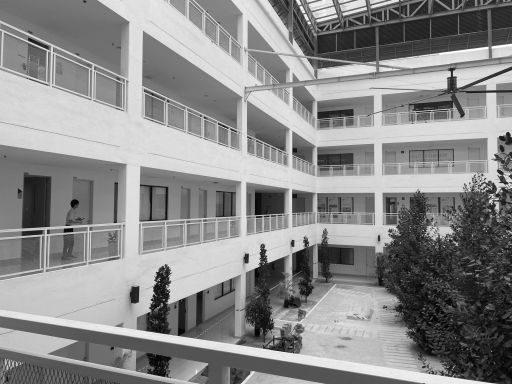

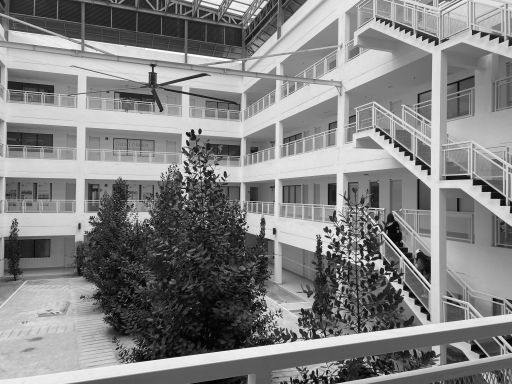

In [ ]:
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

cv2_imshow(gray1)
cv2_imshow(gray2)

In [ ]:
# Define the minimum number of matches required
MIN_MATCH_COUNT = 10
#ORB
orb = cv2.ORB_create(nfeatures=2000)#feature detection method
keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

In [ ]:
image_with_keypoints = cv2.drawKeypoints(image1, keypoints1, None,
color=(0, 255, 0),
flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


In [ ]:
image_with_keypoints_2 = cv2.drawKeypoints(image2, keypoints2, None,
color=(0, 255, 0),
flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

In [ ]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)
# matches = bf.knnMatch(descriptors1, descriptors2,k=2)

matches = sorted(matches, key=lambda x: x.distance)

n = 50
matches = matches[:n]

src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)


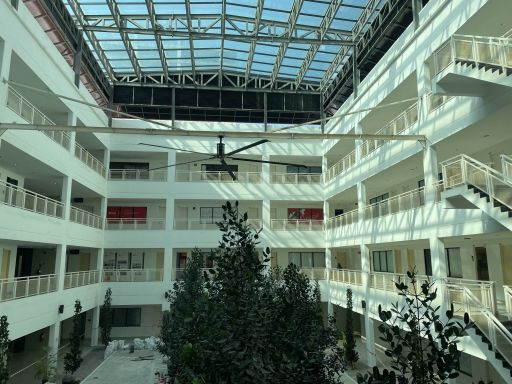

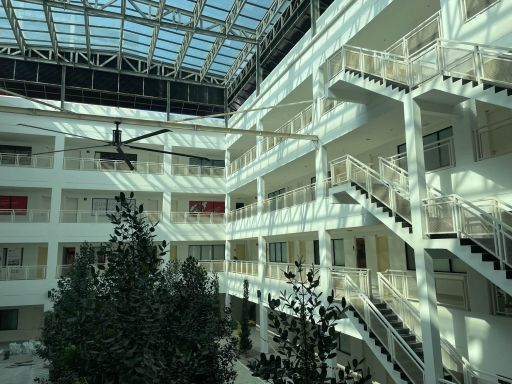

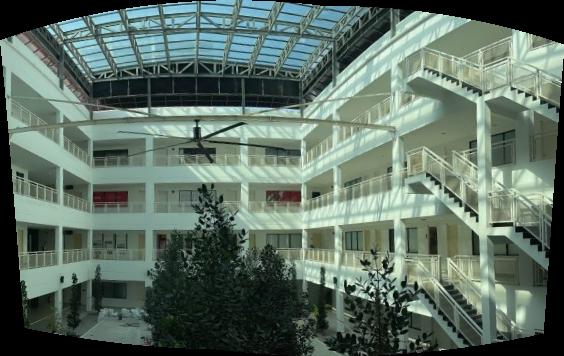

True

In [ ]:
#using the geeks4geeks cv2.Stitcher

image_paths = ['pano_01_L.jpg', 'pano_01_R.jpg']

imgs=[]

for i in range(len(image_paths)):
  imgs.append(cv2.imread(image_paths[i]))
  # imgs[i]=cv2.resize(imgs[i], (0,0), fx=0.4, fy=0.4)

cv2_imshow(imgs[0])
cv2_imshow(imgs[1])

stitchy = cv2.Stitcher.create()
(dummy,output) = stitchy.stitch(imgs)


cv2_imshow(output)
cv2.imwrite('panorama_01.jpg', output)

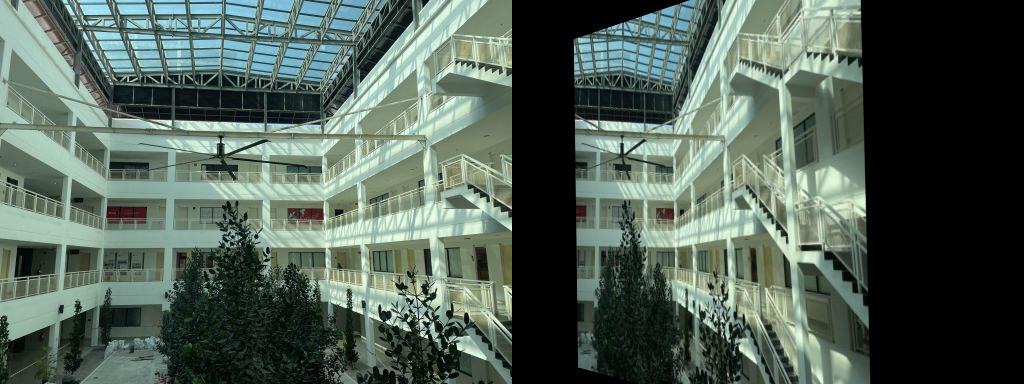

In [ ]:
# Find the homography matrix
M, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

# Warp image 2 to image 1's perspective
height, width = gray1.shape
warped_image2 = cv2.warpPerspective(image2, M, (width * 2, height))

# Resize warped_image2 to match the width of image1
warped_image2_resized = cv2.resize(warped_image2, (image1.shape[1], image1.shape[0]))

# Create a blank canvas for the stitched panorama
panorama_width = width + warped_image2_resized.shape[1]
panorama_height = max(height, warped_image2_resized.shape[0])
panorama = np.zeros((panorama_height, panorama_width, 3), dtype=np.uint8)

# Copy image1 to the left side of the panorama
panorama[0:image1.shape[0], 0:image1.shape[1]] = image1

# Copy warped_image2_resized to the right side of the panorama
panorama[0:warped_image2_resized.shape[0], image1.shape[1]:] = warped_image2_resized

# Display the stitched panorama
cv2_imshow(panorama)

In [ ]:
def warpImages(image1, image2, H):

  rows1, cols1 = image1.shape[:2]
  rows2, cols2 = image2.shape[:2]

  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

  # When we have established a homography we need to warp perspective
  # Change field of view
  list_of_points_2 = cv2.perspectiveTransform(temp_points, H)

  list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)

  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

  translation_dist = [-x_min,-y_min]

  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

  output_img = cv2.warpPerspective(image2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
  output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = image1

  return output_img

In [ ]:
# Find the homography matrix
M, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

# Warp image 2 to image 1's perspective
height, width = gray1.shape
warped_image2 = cv2.warpPerspective(image2, M, (width * 2, height))

# Resize warped_image2 to match the width of image1
warped_image2_resized = cv2.resize(warped_image2, (image1.shape[1], image1.shape[0]))

# Calculate the translation distance based on the width of image1
translation_dist = width

# Create a blank canvas for the stitched panorama
output_width = width + translation_dist
output_height = max(height, warped_image2_resized.shape[0])
output_img = np.zeros((output_height, output_width, 3), dtype=np.uint8)

# Copy image1 to the output_img
output_img[0:image1.shape[0], 0:image1.shape[1]] = image1

# Copy warped_image2_resized to the output_img at the appropriate translation distance
output_img[0:warped_image2_resized.shape[0], translation_dist:translation_dist+warped_image2_resized.shape[1]] = warped_image2_resized

# Display the stitched panorama
cv2_imshow(output_img)


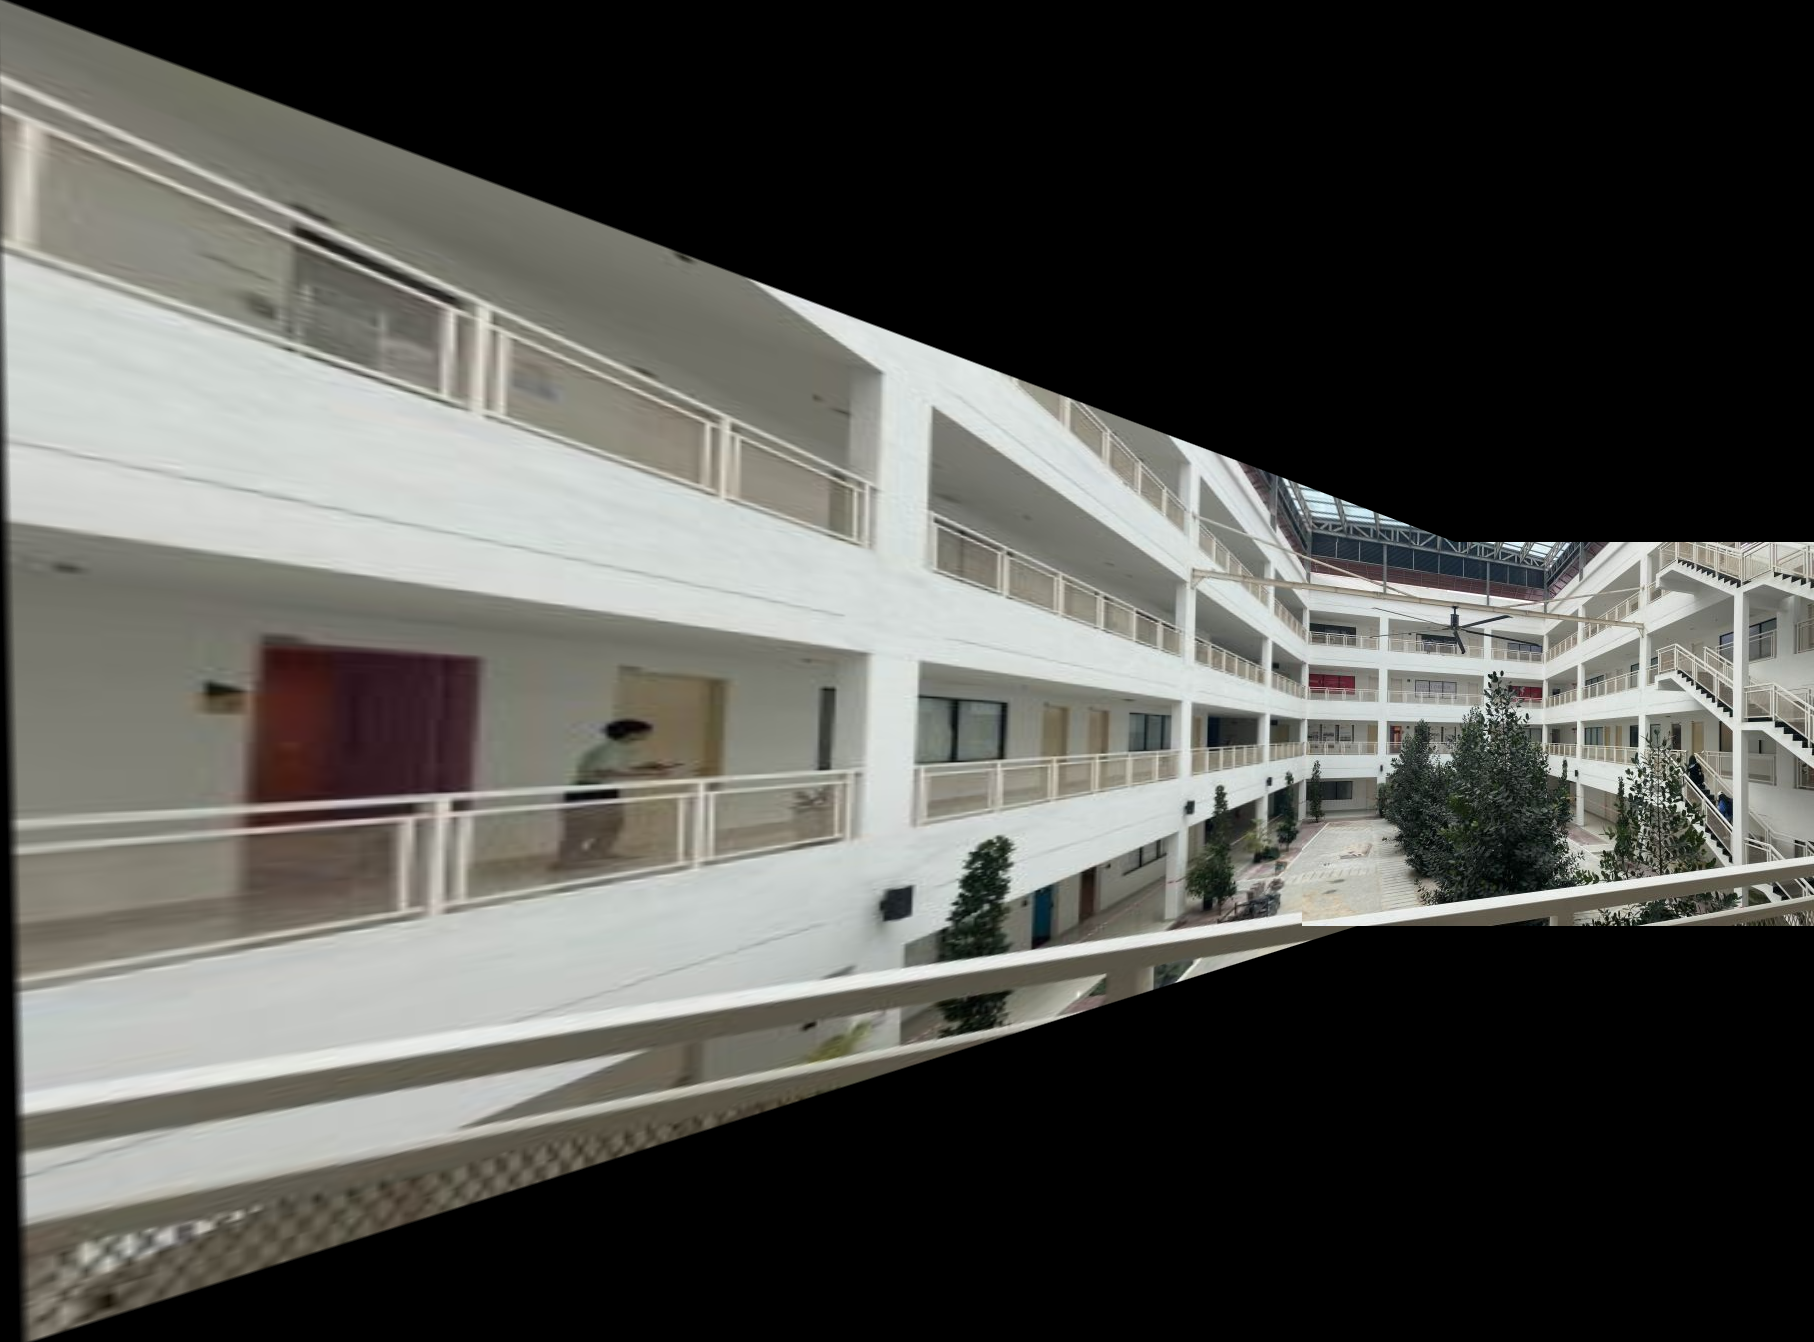

In [ ]:
MIN_MATCH_COUNT = 10

if len(matches) > MIN_MATCH_COUNT:
    # Convert keypoints to an argument for findHomography
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Establish a homography
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # # Warp image2 to image1's perspective
    # result = cv2.warpPerspective(image2, M, (image1.shape[1] + image2.shape[1], image1.shape[0]))

    # # Combine image1 and the warped image2
    # result[0:image1.shape[0], 0:image1.shape[1]] = image1

    result = warpImages(image2, image1, M)

    cv2_imshow(result)

    # cv2_imshow(result)
else:
    print("Not enough matches are found.")